In [2]:
!pip install torch

     -------------------------------------- 212.5/212.5 MB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 6.3/6.3 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 194.4/194.4 kB 1.7 MB/s eta 0:00:00
     -------------------------------------- 536.2/536.2 kB 1.6 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

In [5]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Load preprocessed data
df = pd.read_csv('data/cryogenic_synthetic_preprocessed.csv', parse_dates=['Timestamp'])

In [7]:
df.head()

,Timestamp,Temperature (°C),Anomaly
0,2025-01-01 00:00:00,-0.101215,0
1,2025-01-01 00:01:00,-0.093341,0
2,2025-01-01 00:02:00,-0.060059,0
3,2025-01-01 00:03:00,0.050599,0
4,2025-01-01 00:04:00,-0.089648,0


In [8]:
# Prepare sequences for LSTM input
class CryogenicDataset(Dataset):
    def __init__(self, data, seq_length=30):
        self.seq_length = seq_length
        self.X = []
        self.y = []
        temperatures = data['Temperature (\u00b0C)'].values
        for i in range(len(temperatures) - seq_length):
            self.X.append(temperatures[i:i+seq_length])
            self.y.append(temperatures[i:i+seq_length])  # Autoencoder tries to reconstruct

        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [9]:
# Create dataset
dataset = CryogenicDataset(df, seq_length=30)

C:\Users\Jisan\AppData\Local\Temp\ipykernel_17080\3743446356.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  self.X = torch.tensor(self.X, dtype=torch.float32)


In [10]:
# Train/Test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# Define LSTM Autoencoder model
class LSTMAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(
            input_size=n_features, hidden_size=embedding_dim, num_layers=1, batch_first=True
        )
        self.decoder = nn.LSTM(
            input_size=embedding_dim, hidden_size=n_features, num_layers=1, batch_first=True
        )

    def forward(self, x):
        x = x.unsqueeze(-1)  # (batch_size, seq_len, features)
        encoded, _ = self.encoder(x)
        decoded, _ = self.decoder(encoded)
        decoded = decoded.squeeze(-1)
        return decoded

In [12]:
# Initialize model
model = LSTMAutoencoder(seq_len=30, n_features=1, embedding_dim=64)
model = model.to(device)

In [13]:
# Loss and Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Training the model
n_epochs = 30
train_losses = []
test_losses = []

for epoch in range(1, n_epochs+1):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            output = model(batch_X)
            loss = criterion(output, batch_y)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Epoch {epoch}: Train Loss = {train_loss:.6f}, Test Loss = {test_loss:.6f}")

Epoch 1: Train Loss = 0.947726, Test Loss = 1.139016
Epoch 2: Train Loss = 0.914826, Test Loss = 1.137285
Epoch 3: Train Loss = 0.913620, Test Loss = 1.136609
Epoch 4: Train Loss = 0.912959, Test Loss = 1.136212
Epoch 5: Train Loss = 0.912557, Test Loss = 1.135933
Epoch 6: Train Loss = 0.914223, Test Loss = 1.135739
Epoch 7: Train Loss = 0.914029, Test Loss = 1.135592
Epoch 8: Train Loss = 0.914758, Test Loss = 1.135484
Epoch 9: Train Loss = 0.914685, Test Loss = 1.135399
Epoch 10: Train Loss = 0.911771, Test Loss = 1.135329
Epoch 11: Train Loss = 0.913935, Test Loss = 1.135275
Epoch 12: Train Loss = 0.913548, Test Loss = 1.135232
Epoch 13: Train Loss = 0.913517, Test Loss = 1.135199
Epoch 14: Train Loss = 0.913465, Test Loss = 1.135169
Epoch 15: Train Loss = 0.914370, Test Loss = 1.135145
Epoch 16: Train Loss = 0.916233, Test Loss = 1.135122
Epoch 17: Train Loss = 0.914268, Test Loss = 1.135100
Epoch 18: Train Loss = 0.913825, Test Loss = 1.135080
Epoch 19: Train Loss = 0.911395, Test

In [15]:
# Save model checkpoint
torch.save(model.state_dict(), 'outputs/frostnet_lstm_autoencoder.pth')
print("\n✅ Model saved successfully!")


✅ Model saved successfully!


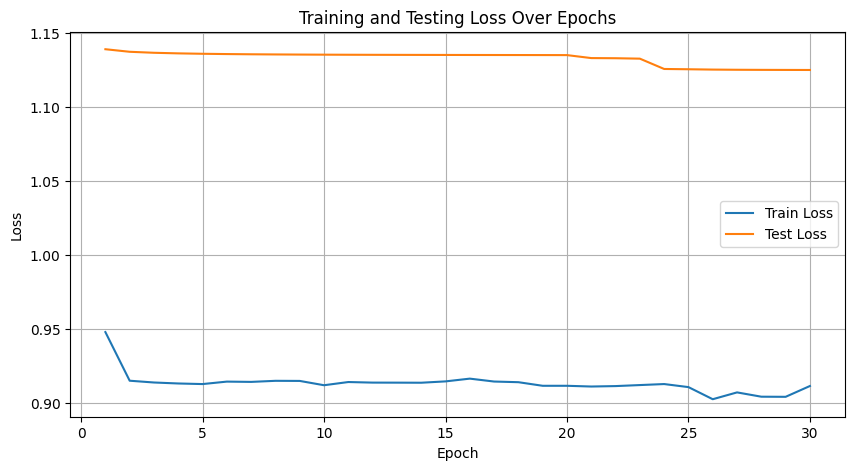

In [16]:
# Plot Training and Testing Loss
plt.figure(figsize=(10,5))
plt.plot(range(1, n_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, n_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()